CuPy GPU加速可用，设备:  0
开始小波变换特征提取和比较处理（使用余弦相似度，GPU加速）...
处理Stable文件夹: E:\Desktop\Data_Set\stable
在 E:\Desktop\Data_Set\stable 中找到 307 对匹配文件

开始提取 307 对图像的特征...


特征提取: 100%|██████████| 307/307 [07:18<00:00,  1.43s/it]



开始计算 307 对特征的余弦相似度（GPU加速）...


相似度计算: 100%|██████████| 307/307 [00:00<00:00, 1069.17it/s]



特征统计信息:
  特征维度: (614, 22)
  均值范围: [-0.0089, 1711.5406]
  标准差范围: [0.0001, 1514.6382]

所有 307 对处理完成

处理Non-Stable文件夹: E:\Desktop\Data_Set\non-stable
在 E:\Desktop\Data_Set\non-stable 中找到 298 对匹配文件

开始提取 298 对图像的特征...


特征提取: 100%|██████████| 298/298 [07:11<00:00,  1.45s/it]



开始计算 298 对特征的余弦相似度（GPU加速）...


相似度计算: 100%|██████████| 298/298 [00:00<00:00, 3383.93it/s]



特征统计信息:
  特征维度: (596, 22)
  均值范围: [-0.0101, 1674.0712]
  标准差范围: [0.0001, 2265.0294]

所有 298 对处理完成

总处理时间: 870.89秒

=== 统计结果 ===
Stable组: 平均余弦相似度 = 0.9488, 平均余弦距离 = 0.0512
Non-Stable组: 平均余弦相似度 = 0.9467, 平均余弦距离 = 0.0533


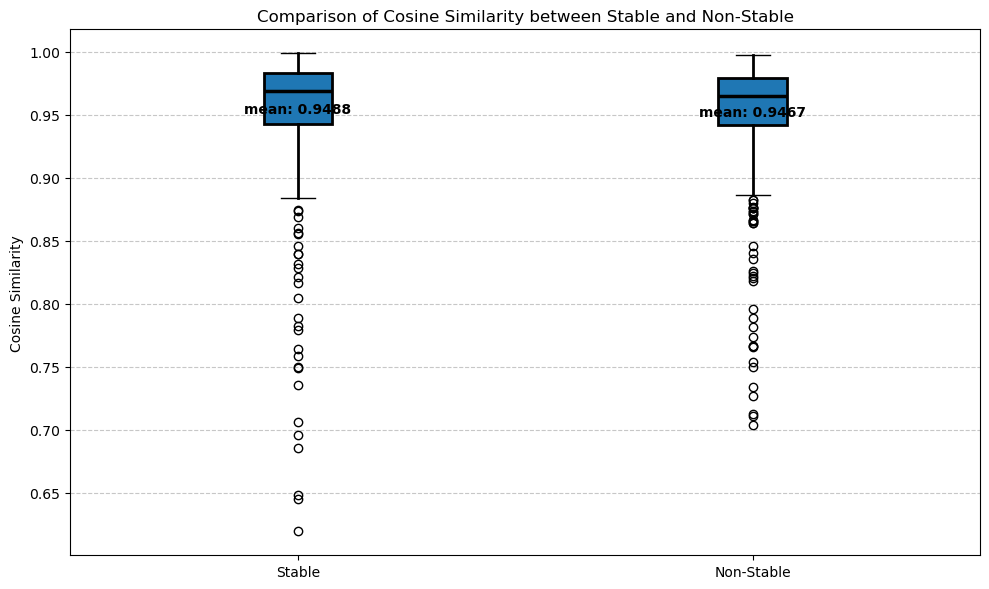

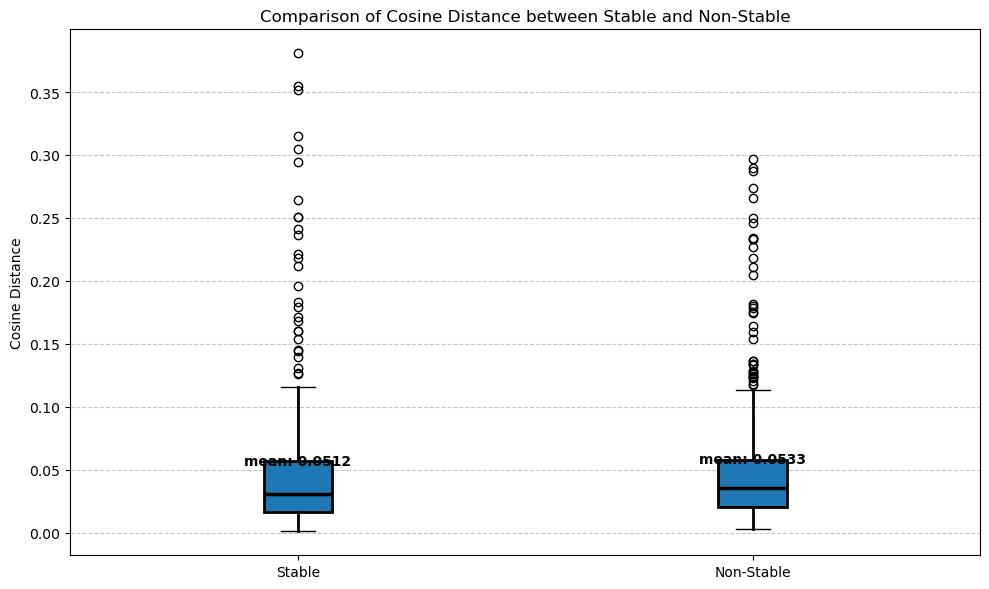

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import pywt
import time
import cupy as cp
import math
from tqdm import tqdm  

def extract_wavelet_features(image_path):
    """使用小波变换提取图像特征（全GPU加速版）"""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image.shape[0] % 2 != 0:
        image = image[:-1, :]
    if image.shape[1] % 2 != 0:
        image = image[:, :-1]

    image_gpu = cp.asarray(image, dtype=cp.float32)

    image_cpu = cp.asnumpy(image_gpu)
    coeffs = pywt.wavedec2(image_cpu, 'db1', level=3)

    cA3_gpu = cp.asarray(coeffs[0])
    detail_coeffs_gpu = [cp.asarray(c) for c in coeffs[1:]]
    
    features = []

    features.extend([float(cp.mean(cA3_gpu)), float(cp.std(cA3_gpu)), 
                    float(cp.max(cA3_gpu)), float(cp.min(cA3_gpu))])

    for detail_coeffs in detail_coeffs_gpu:
        flat_coeffs = detail_coeffs.flatten()
        energy = cp.sum(flat_coeffs ** 2) / flat_coeffs.size
        std = cp.std(flat_coeffs)
        features.extend([float(energy), float(std)])

    for detail_coeffs in detail_coeffs_gpu[:3]:
        normalized = detail_coeffs / 255.0
        normalized_flat = normalized.flatten()
        
        mean_val = cp.mean(normalized_flat)
        contrast = cp.mean((normalized_flat - mean_val) ** 2)
        energy = cp.sum(normalized_flat ** 2)
        
        arange = cp.arange(normalized_flat.size)
        homogeneity = cp.sum(normalized_flat / (1 + cp.abs(arange - mean_val * normalized_flat.size)))

        roll_gpu = cp.roll(normalized_flat, 1)
        correlation = cp.corrcoef(normalized_flat, roll_gpu)[0, 1]
        
        features.extend([float(contrast), float(correlation), float(energy), float(homogeneity)])
    
    return np.array(features)

def cosine_similarity_gpu(vec1, vec2):
    """使用GPU计算余弦相似度（方向相似度）"""
    vec1_gpu = cp.asarray(vec1, dtype=cp.float32)
    vec2_gpu = cp.asarray(vec2, dtype=cp.float32)

    dot_product = cp.dot(vec1_gpu, vec2_gpu)
    norm_product = cp.linalg.norm(vec1_gpu) * cp.linalg.norm(vec2_gpu)

    similarity = dot_product / (norm_product + 1e-8)
    
    return float(similarity)

def process_folder(folder, prefix1, prefix2):
    """处理单个文件夹内的配对比较（使用GPU加速和余弦相似度）"""
    similarities = []
    distances = []  
    pattern = r'^(\d{2})-(\d{4})'

    prefix1_dict = {}
    prefix2_dict = {}

    for filename in os.listdir(folder):
        if not os.path.isfile(os.path.join(folder, filename)):
            continue

        match = re.match(pattern, filename)
        if not match:
            continue
            
        prefix, pair_id = match.groups()
        
        if prefix == prefix1:
            prefix1_dict[pair_id] = filename
        elif prefix == prefix2:
            prefix2_dict[pair_id] = filename
    
    common_pairs = set(prefix1_dict.keys()) & set(prefix2_dict.keys())
    print(f"在 {folder} 中找到 {len(common_pairs)} 对匹配文件")

    if len(common_pairs) == 0:
        print(f"警告: 在 {folder} 中未找到匹配的文件对")
        return [], []

    all_features = []
    feature_pairs = []
    valid_pairs = [] 

    print(f"\n开始提取 {len(common_pairs)} 对图像的特征...")
    for pair_id in tqdm(sorted(common_pairs), desc="特征提取"):
        try:
            file1 = prefix1_dict[pair_id]
            file2 = prefix2_dict[pair_id]
            
            path1 = os.path.join(folder, file1)
            path2 = os.path.join(folder, file2)

            features1 = extract_wavelet_features(path1)
            features2 = extract_wavelet_features(path2)
            
            all_features.extend([features1, features2])
            feature_pairs.append((len(all_features) - 2, len(all_features) - 1))
            valid_pairs.append(pair_id)
            
        except Exception as e:
            print(f"\n提取配对 {pair_id} 的特征时出错: {e}")
            continue

    total_pairs = len(feature_pairs)
    print(f"\n开始计算 {total_pairs} 对特征的余弦相似度（GPU加速）...")

    all_features_gpu = cp.asarray(all_features, dtype=cp.float32)

    for i, (idx1, idx2) in enumerate(tqdm(feature_pairs, desc="相似度计算")):
        pair_id = valid_pairs[i]

        vec1_gpu = all_features_gpu[idx1]
        vec2_gpu = all_features_gpu[idx2]
   
        sim = cosine_similarity_gpu(vec1_gpu, vec2_gpu)

        dist = 1.0 - sim
        
        similarities.append(sim)
        distances.append(dist)

    if all_features:
        features_matrix = np.vstack(all_features)
        print(f"\n特征统计信息:")
        print(f"  特征维度: {features_matrix.shape}")
        print(f"  均值范围: [{np.min(np.mean(features_matrix, axis=0)):.4f}, {np.max(np.mean(features_matrix, axis=0)):.4f}]")
        print(f"  标准差范围: [{np.min(np.std(features_matrix, axis=0)):.4f}, {np.max(np.std(features_matrix, axis=0)):.4f}]")
    
    print(f"\n所有 {total_pairs} 对处理完成")
    return similarities, distances

if __name__ == "__main__":

    try:
        cp.cuda.Device(0).compute_capability
        print("CuPy GPU加速可用，设备: ", cp.cuda.get_device_id())
    except:
        print("警告: CuPy不可用，程序将在CPU上运行")

    stable_folder = "../../../datasets/stable"
    non_stable_folder = "../../../datasets/non-stable"

    try:
        print(f"开始小波变换特征提取和比较处理（使用余弦相似度，GPU加速）...")
        start_time = time.time()
        
        print(f"处理Stable文件夹: {stable_folder}")
        stable_sims, stable_dists = process_folder(stable_folder, "10", "11")
        
        print(f"\n处理Non-Stable文件夹: {non_stable_folder}")
        non_stable_sims, non_stable_dists = process_folder(non_stable_folder, "00", "01")

        if not stable_sims or not non_stable_sims:
            raise ValueError("至少有一组数据为空，请检查文件夹中的文件格式和配对情况")
        
        total_time = time.time() - start_time
        print(f"\n总处理时间: {total_time:.2f}秒")

        stable_mean_sim = np.mean(stable_sims)
        stable_mean_dist = np.mean(stable_dists)
        non_stable_mean_sim = np.mean(non_stable_sims)
        non_stable_mean_dist = np.mean(non_stable_dists)
        
        print("\n=== 统计结果 ===")
        print(f"Stable组: 平均余弦相似度 = {stable_mean_sim:.4f}, 平均余弦距离 = {stable_mean_dist:.4f}")
        print(f"Non-Stable组: 平均余弦相似度 = {non_stable_mean_sim:.4f}, 平均余弦距离 = {non_stable_mean_dist:.4f}")
        
    except Exception as e:
        print(f"处理过程中出错: {e}")
        stable_sims = [0.5]
        non_stable_sims = [0.3]
        stable_dists = [0.5]
        non_stable_dists = [0.7]
        print("已设置默认值用于绘图演示")

    plt.figure(figsize=(10, 6))
    boxprops = dict(linestyle='-', linewidth=2)
    whiskerprops = dict(linestyle='-', linewidth=2)
    medianprops = dict(linestyle='-', linewidth=2.5, color='black')

    plt.boxplot([stable_sims, non_stable_sims], 
                tick_labels=['Stable', 'Non-Stable'],  
                patch_artist=True,
                boxprops=boxprops,
                whiskerprops=whiskerprops,
                medianprops=medianprops)
    
    colors = ['#1f77b4', '#ff7f0e']
    ax = plt.gca()
    for patch, color in zip(ax.artists, colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    plt.ylabel('Cosine Similarity')
    plt.title('Comparison of Cosine Similarity between Stable and Non-Stable')
    
    stable_mean_sim = np.mean(stable_sims)
    non_stable_mean_sim = np.mean(non_stable_sims)
    
    plt.text(1, stable_mean_sim, f'mean: {stable_mean_sim:.4f}', ha='center', va='bottom', fontweight='bold')
    plt.text(2, non_stable_mean_sim, f'mean: {non_stable_mean_sim:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('wavelet_cosine_similarity_comparison_gpu.png', dpi=300, bbox_inches='tight')

    plt.figure(figsize=(10, 6))
    plt.boxplot([stable_dists, non_stable_dists], 
                tick_labels=['Stable', 'Non-Stable'],  
                patch_artist=True,
                boxprops=boxprops,
                whiskerprops=whiskerprops,
                medianprops=medianprops)
    
    for patch, color in zip(ax.artists, colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    plt.ylabel('Cosine Distance')
    plt.title('Comparison of Cosine Distance between Stable and Non-Stable')
    
    stable_mean_dist = np.mean(stable_dists)
    non_stable_mean_dist = np.mean(non_stable_dists)
    
    plt.text(1, stable_mean_dist, f'mean: {stable_mean_dist:.4f}', ha='center', va='bottom', fontweight='bold')
    plt.text(2, non_stable_mean_dist, f'mean: {non_stable_mean_dist:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('wavelet_cosine_distance_comparison_gpu.png', dpi=300, bbox_inches='tight')
    
    plt.show()    